In [4]:
# ## 2. Data Loading and Preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# Load dataset
cell1 = pd.read_csv("Churn_Data_cleaned.csv")

# Drop columns with >50% missing data
cell1 = cell1.loc[:, cell1.isnull().mean() < 0.5]

In [5]:

# Drop high-cardinality categorical columns
high_card_cols = [col for col in cell1.columns if cell1[col].dtype == 'object' and cell1[col].nunique() > 50]
cell1.drop(columns=high_card_cols, inplace=True)


In [6]:
# Fill missing numeric values
for col in cell1.select_dtypes(include=['float64', 'int64']):
    cell1[col] = cell1[col].fillna(cell1[col].median())


In [7]:
# One-hot encode categoricals
cell1_encoded = pd.get_dummies(cell1, drop_first=True)

In [8]:
# Remove low variance and high correlation features
selector = VarianceThreshold(0.01)
X = selector.fit_transform(cell1_encoded)
columns = cell1_encoded.columns[selector.get_support()]
cell1_reduced = pd.DataFrame(X, columns=columns)

In [9]:
corr_matrix = cell1_reduced.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
cell1_final = cell1_reduced.drop(columns=to_drop)

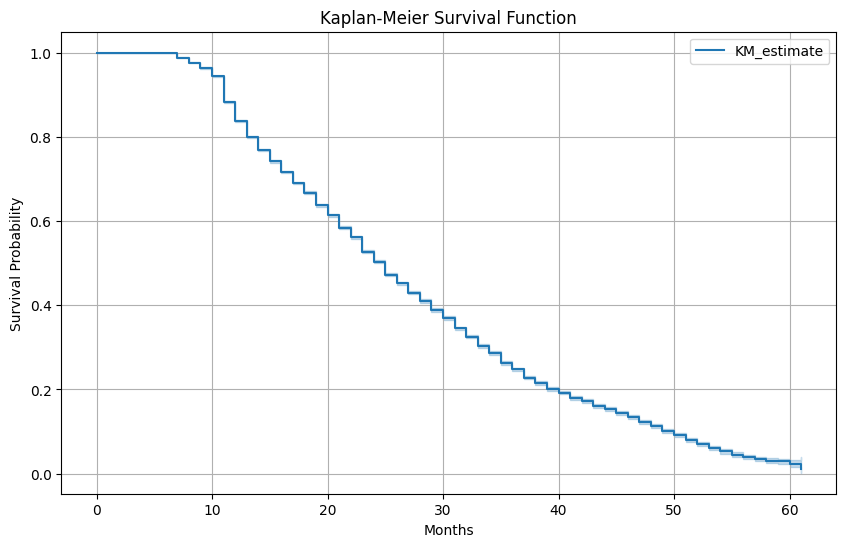

In [10]:
# ## 3. Kaplan-Meier Survival Estimation

from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
kmf.fit(durations=cell1_final['months'], event_observed=cell1_final['churn'])
kmf.plot_survival_function()
plt.title("Kaplan-Meier Survival Function")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


<lifelines.CoxPHFitter: fitted with 93893 total observations, 47177 right-censored observations>
             duration col = 'months'
                event col = 'churn'
                penalizer = 0.5
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 93893
number of events observed = 46716
   partial log-likelihood = -473707.44
         time fit was run = 2025-05-18 17:08:28 UTC

---
                                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                           
rev_Mean                            0.00      1.00      0.00            0.00            0.00                1.00                1.00
mou_Mean                            0.00      1.00      0.00            0.00            0.00                1.00                1.00
totmrc_Mean                         0.00      1.00      0.00            0.00            0.00                1.00                1.00
da_Mean                             0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ovrmou_Mean                         0.00      1.00      0.00            0.00            0.00                1.00                1.00
datovr_Mean                        -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
roam_Mean                           0.00      1.00      0.00           -0.00            0.00                1.00                1.00
change_mou                         -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
change_rev                          0.00      1.00      0.00            0.00            0.00                1.00                1.00
drop_vce_Mean                       0.00      1.00      0.00            0.00            0.00                1.00                1.00
drop_dat_Mean                       0.01      1.01      0.02           -0.03            0.05                0.97                1.06
blck_vce_Mean                       0.00      1.00      0.00            0.00            0.00                1.00                1.00
blck_dat_Mean                       0.05      1.05      0.03           -0.01            0.12                0.99                1.12
unan_vce_Mean                       0.00      1.00      0.00            0.00            0.00                1.00                1.00
unan_dat_Mean                       0.05      1.05      0.02            0.01            0.08                1.01                1.09
recv_vce_Mean                      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
comp_vce_Mean                      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
comp_dat_Mean                      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
custcare_Mean                       0.00      1.00      0.00           -0.00            0.00                1.00                1.00
ccrndmou_Mean                      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
threeway_Mean                      -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
mou_cvce_Mean                      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
mou_cdat_Mean                      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
mou_rvce_Mean                      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
owylis_vce_Mean                    -0.00      1.00      0.00           -0.00            0.00                

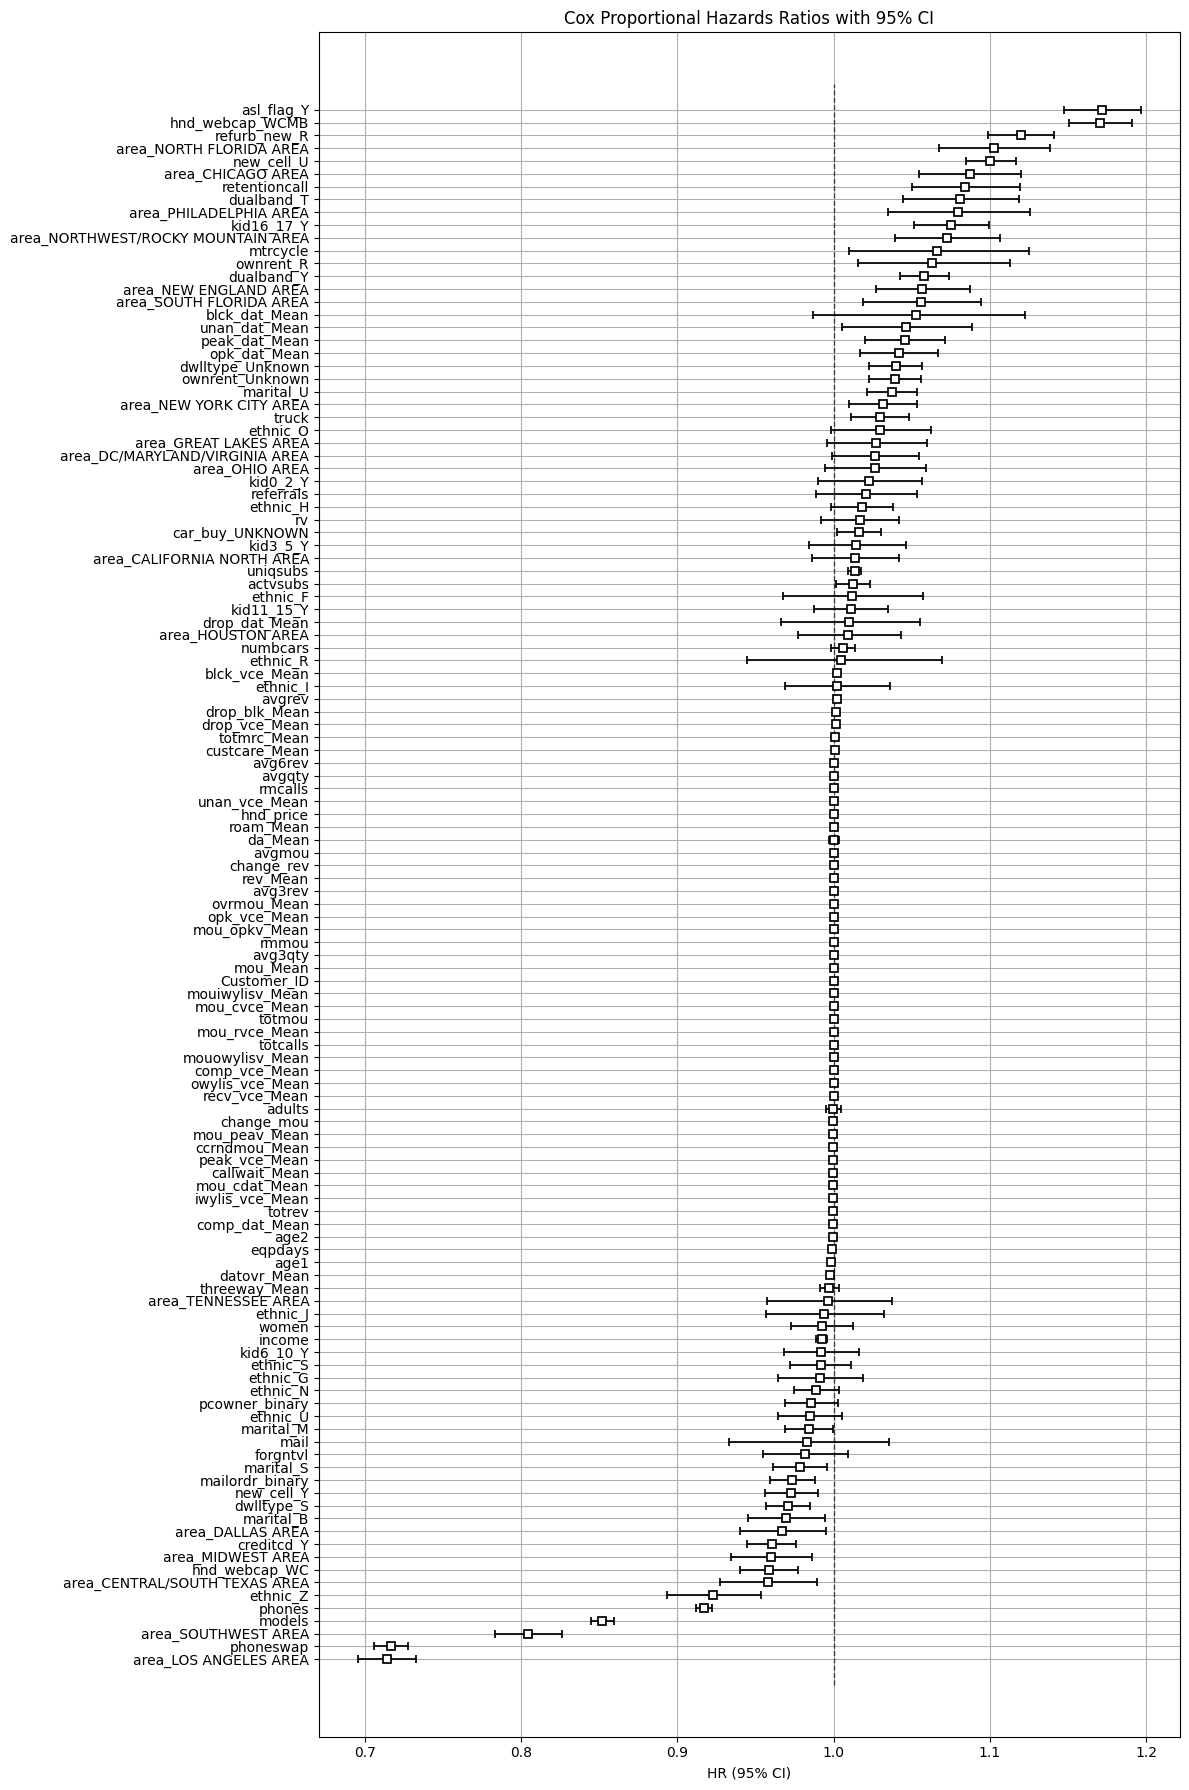

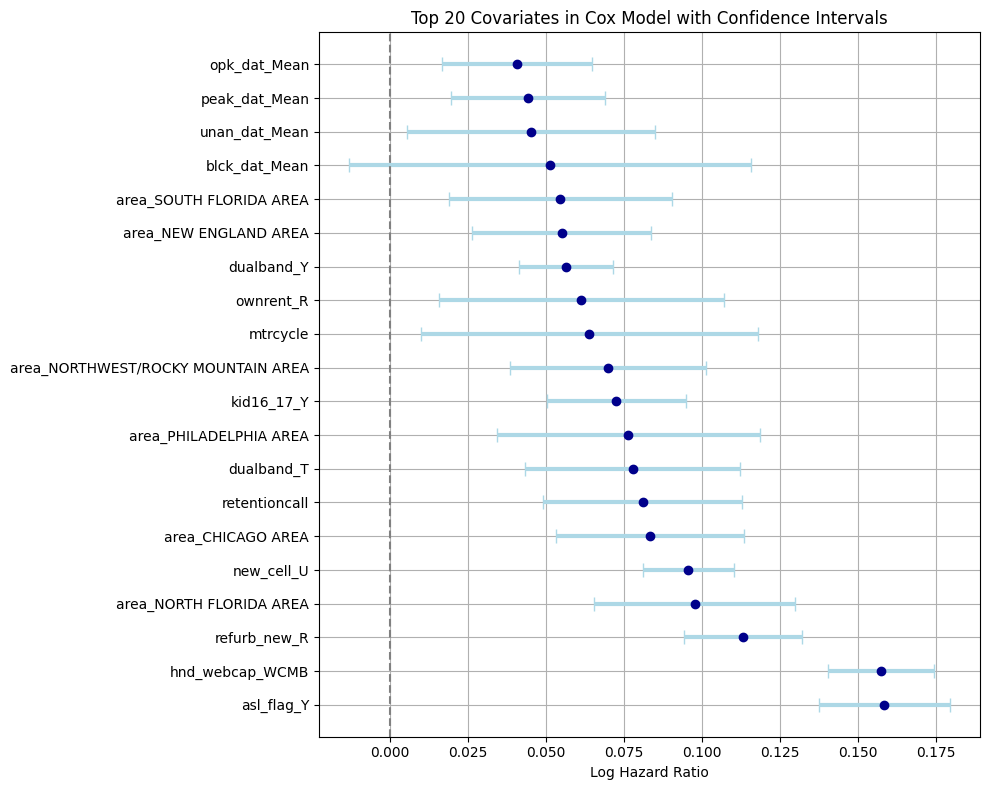

<Figure size 1000x600 with 0 Axes>

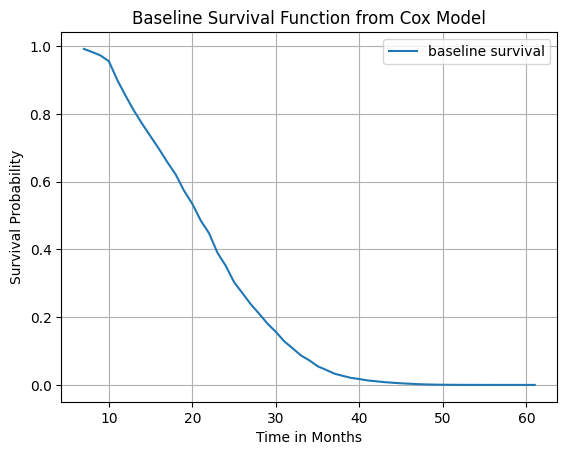

<Figure size 1000x600 with 0 Axes>

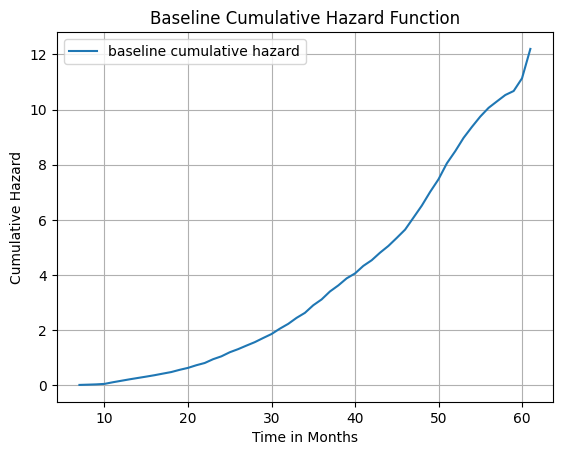

In [18]:
# ## 4. Cox Proportional Hazards Model

from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.5)
cph.fit(cell1_final, duration_col='months', event_col='churn')
cph.print_summary()

plt.figure(figsize=(12, 18))
cph.plot(hazard_ratios=True)

plt.title("Cox Proportional Hazards Ratios with 95% CI")
plt.grid(True)
plt.tight_layout()
plt.show()

# Forest-style plot
summary_df = cph.summary.sort_values(by='coef', ascending=False)
top_vars = summary_df.head(20)

plt.figure(figsize=(10, 8))
plt.errorbar(top_vars['coef'], top_vars.index,
             xerr=(top_vars['coef upper 95%'] - top_vars['coef']),
             fmt='o', color='darkblue', ecolor='lightblue', elinewidth=3, capsize=5)
plt.axvline(0, linestyle='--', color='grey')
plt.xlabel('Log Hazard Ratio')
plt.title('Top 20 Covariates in Cox Model with Confidence Intervals')
plt.grid(True)
plt.tight_layout()
plt.show()

# Baseline survival function
plt.figure(figsize=(10, 6))
cph.baseline_survival_.plot()
plt.title("Baseline Survival Function from Cox Model")
plt.xlabel("Time in Months")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

# Baseline cumulative hazard
plt.figure(figsize=(10, 6))
cph.baseline_cumulative_hazard_.plot()
plt.title("Baseline Cumulative Hazard Function")
plt.xlabel("Time in Months")
plt.ylabel("Cumulative Hazard")
plt.grid(True)
plt.show()


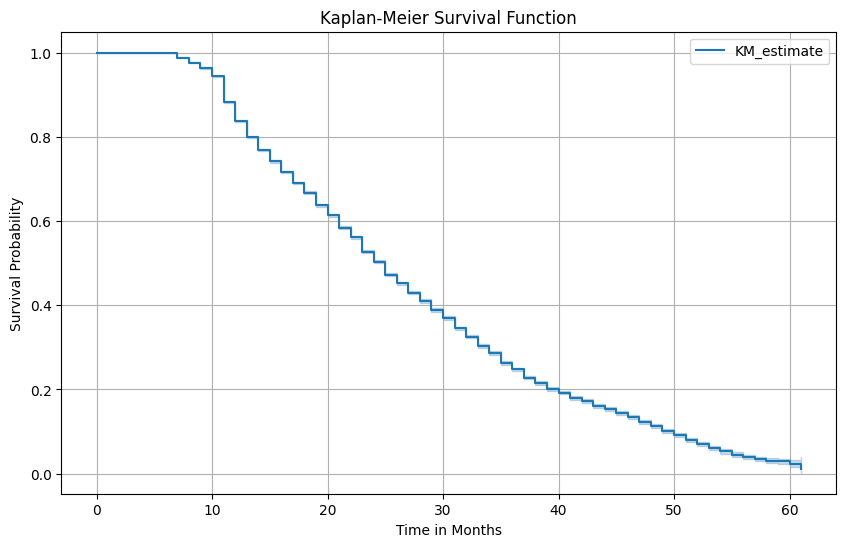

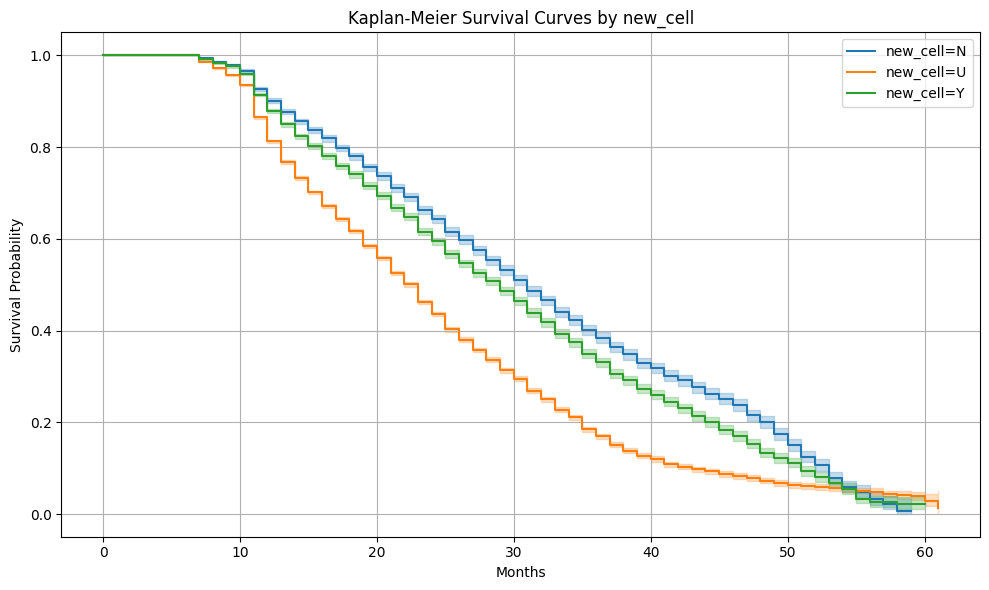

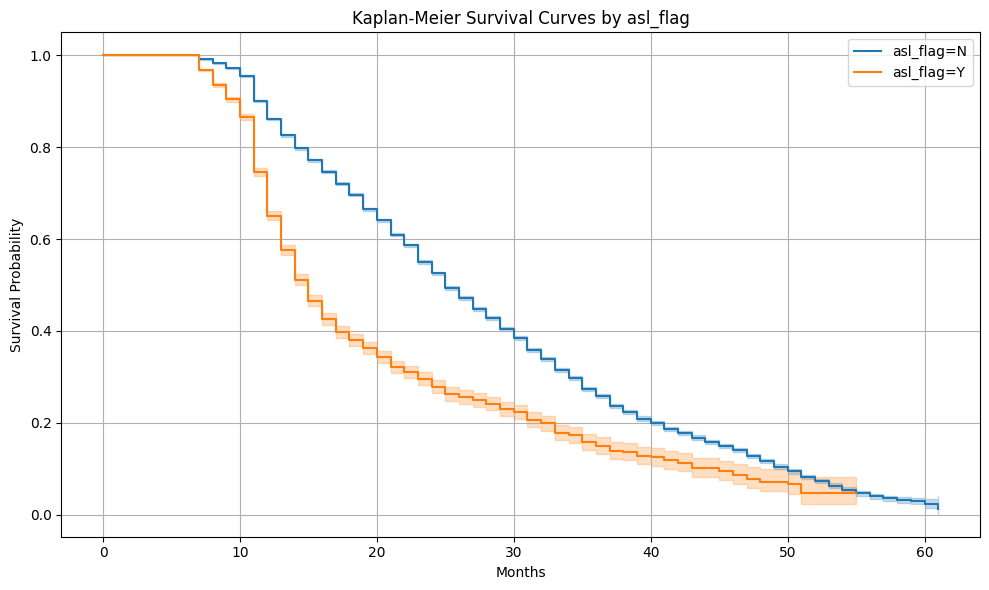

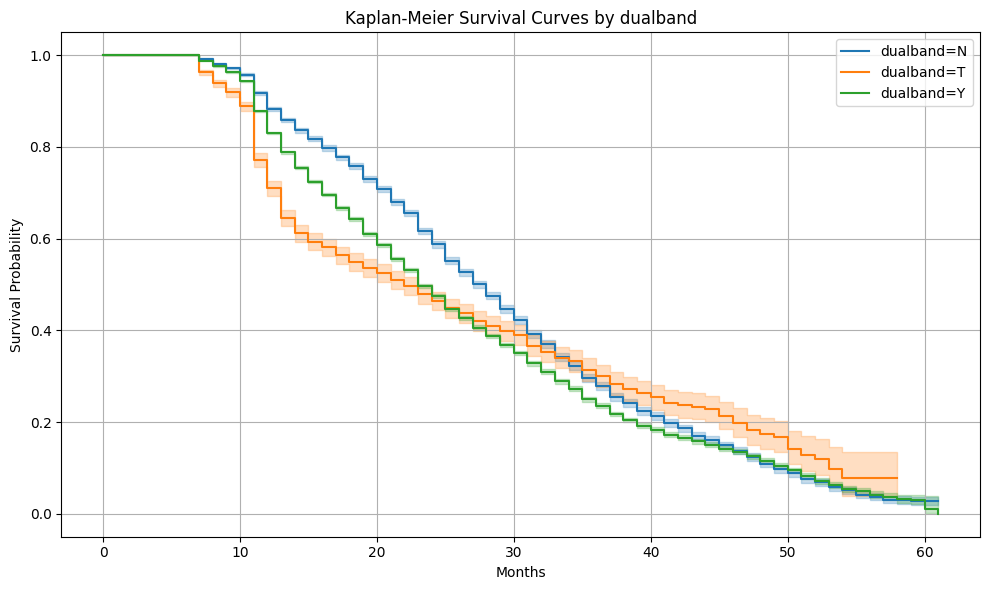

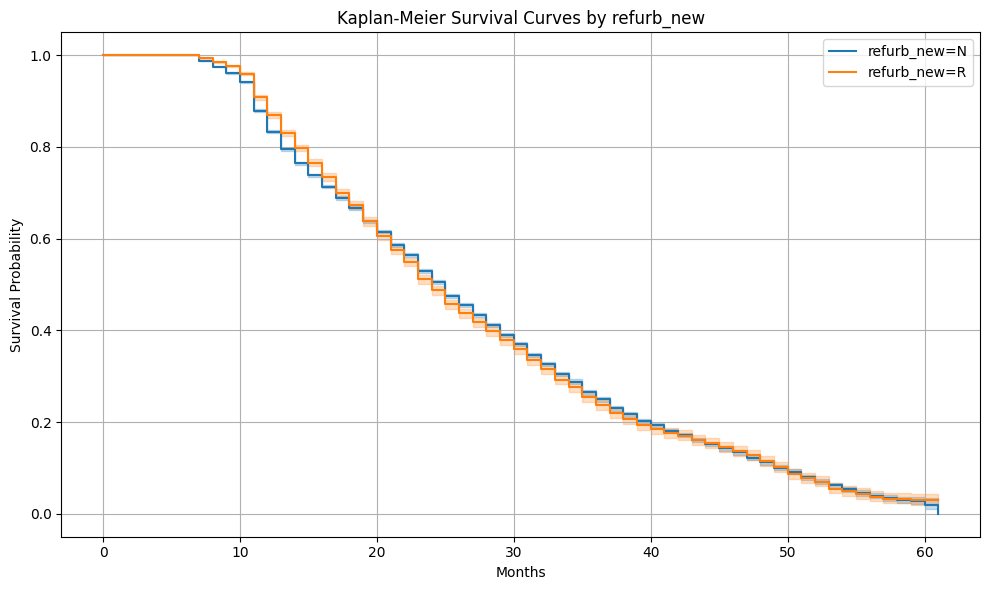

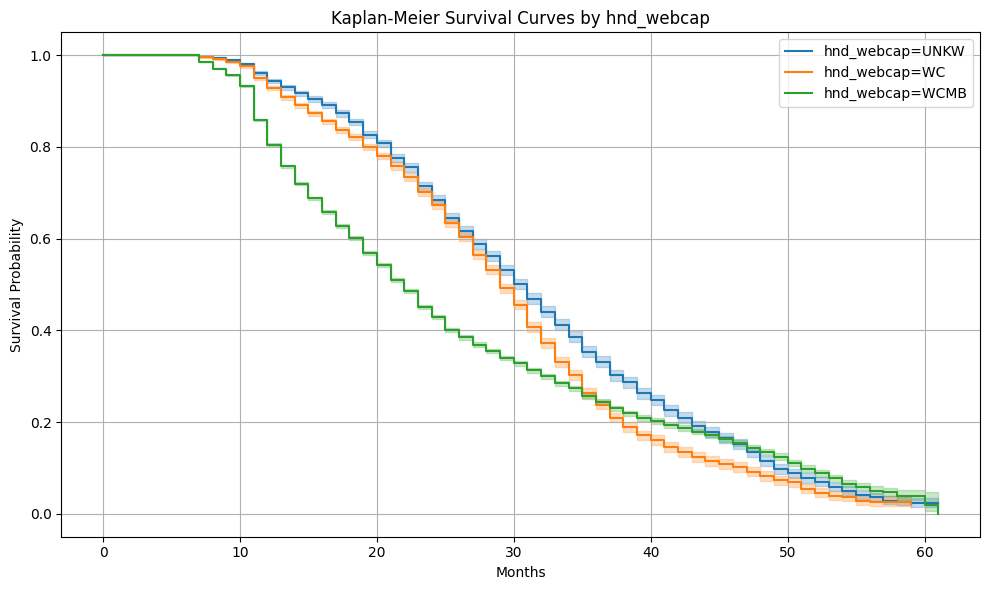

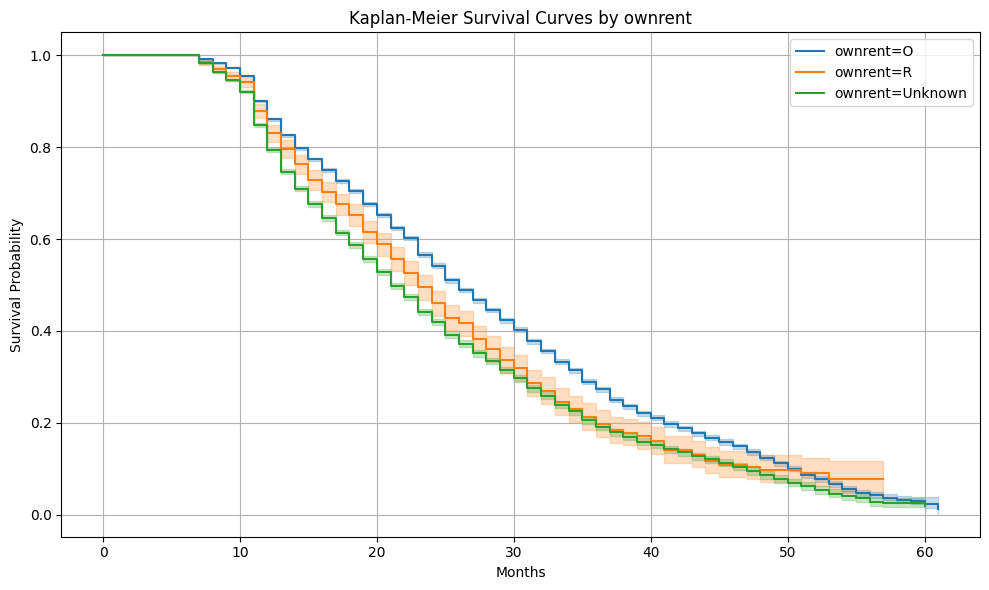

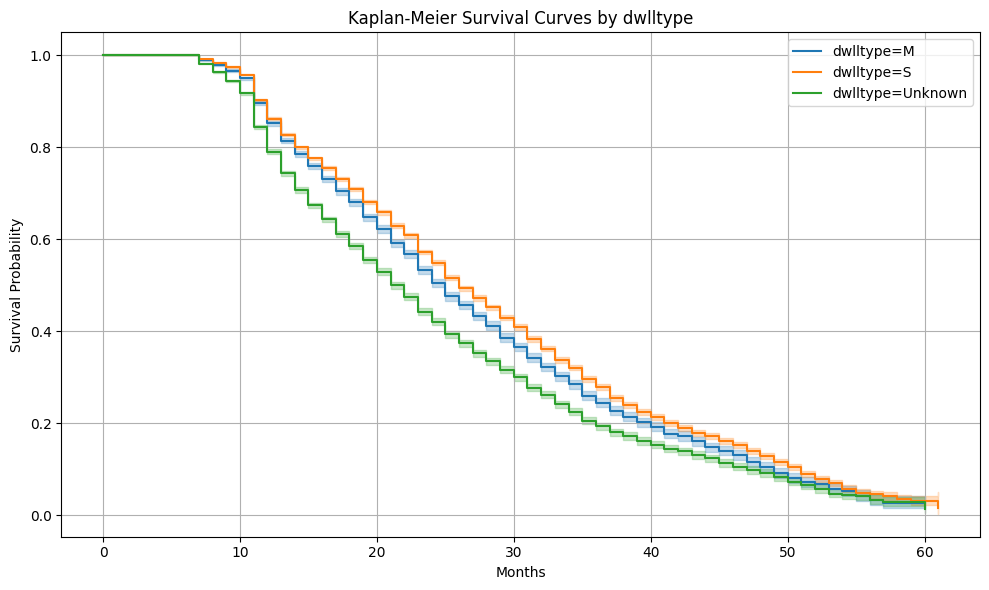

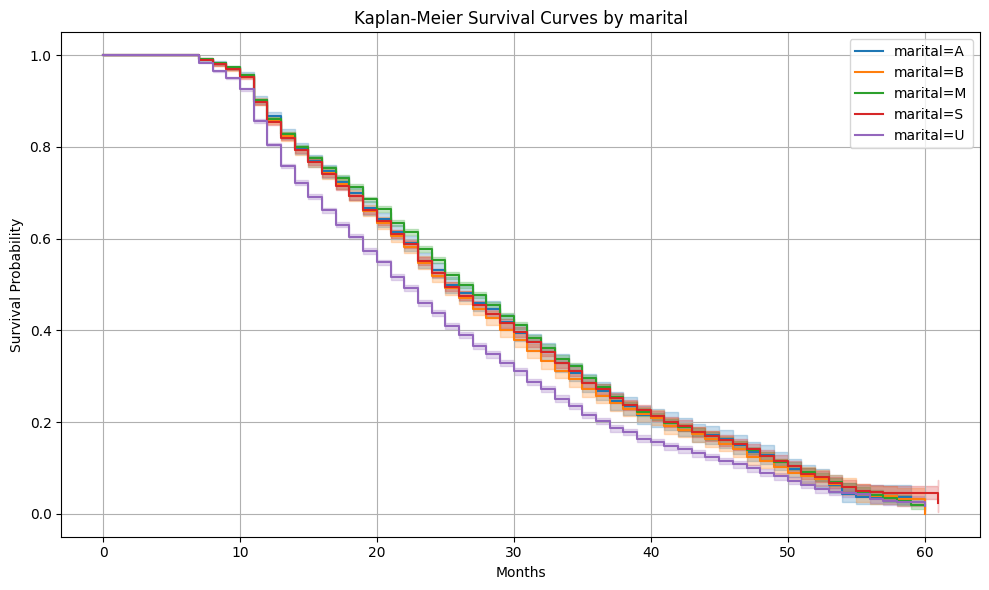

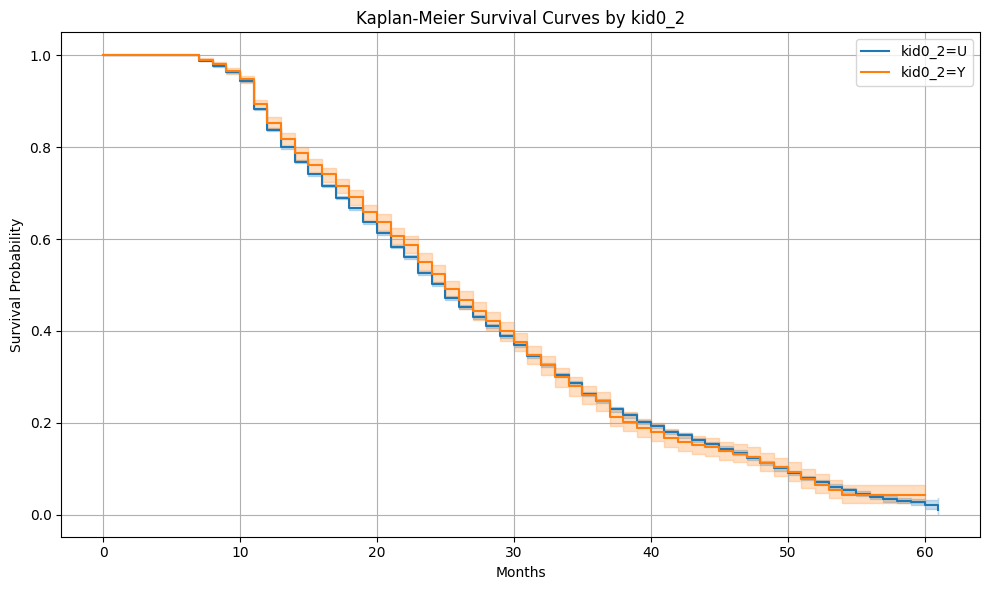

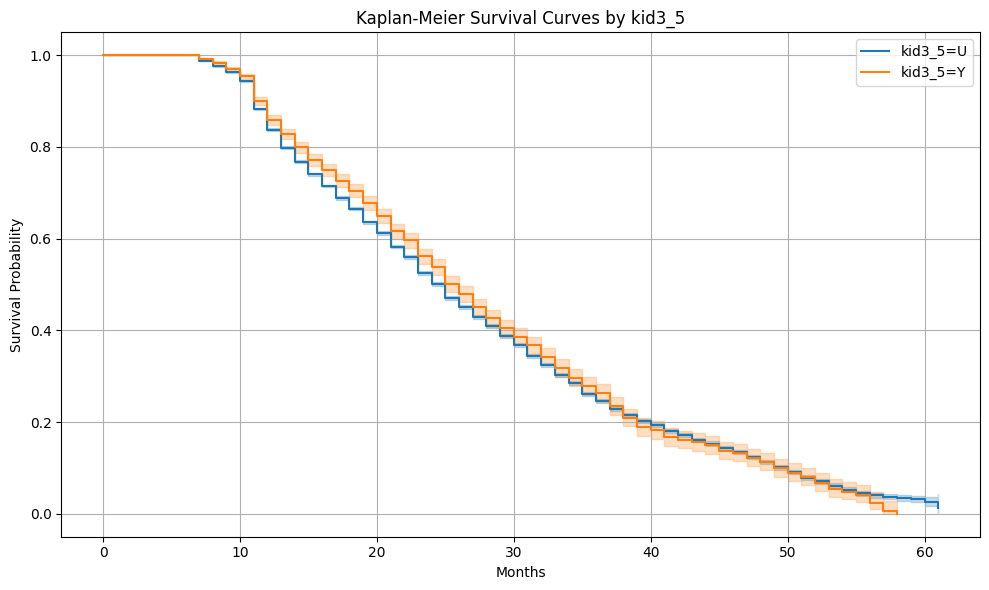

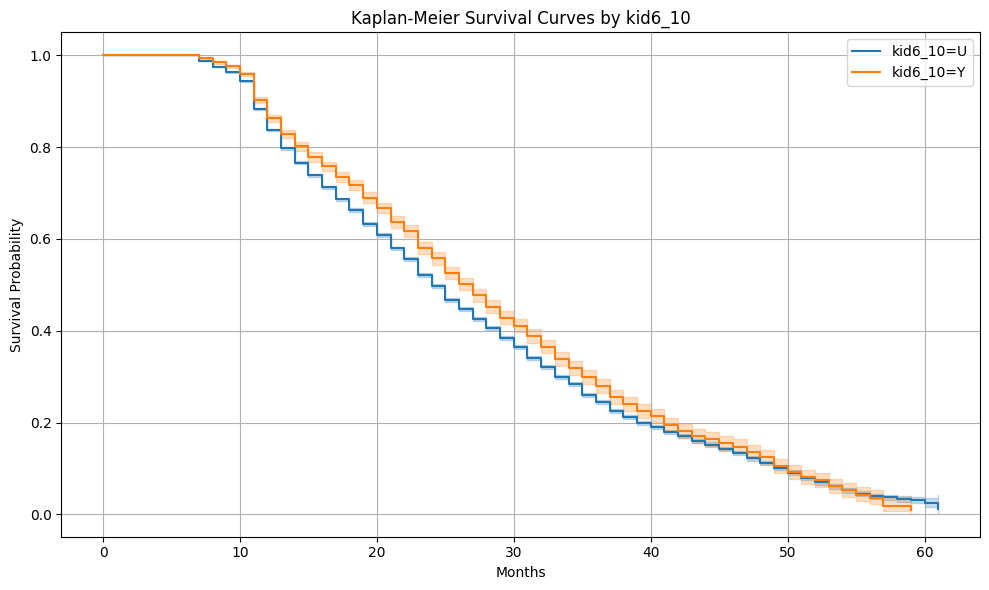

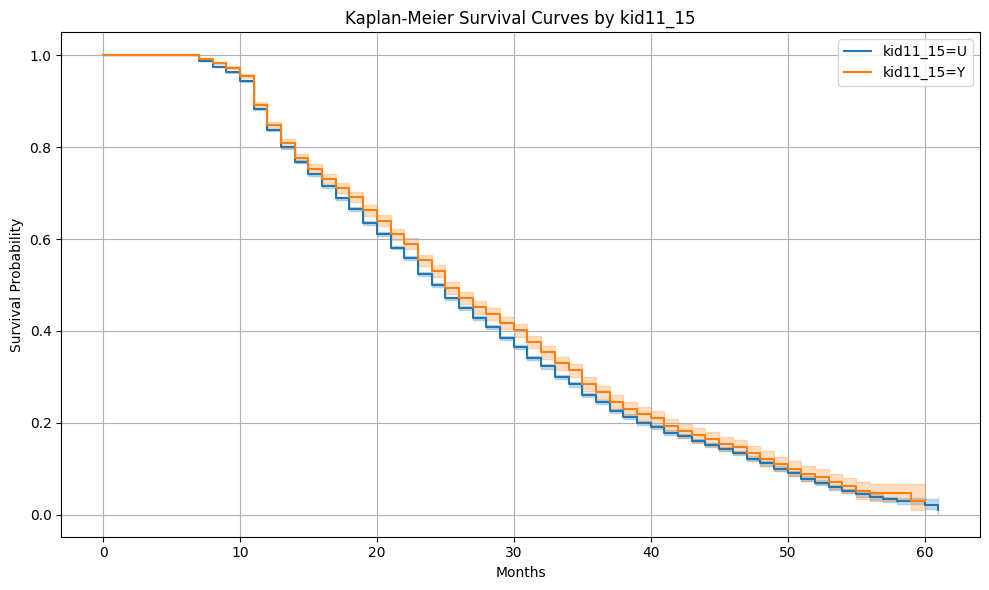

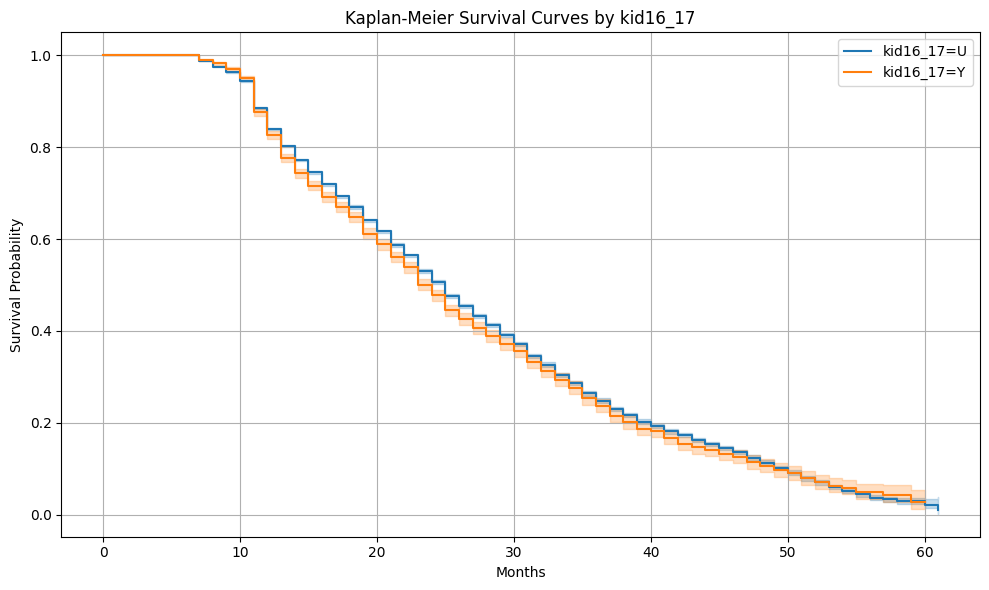

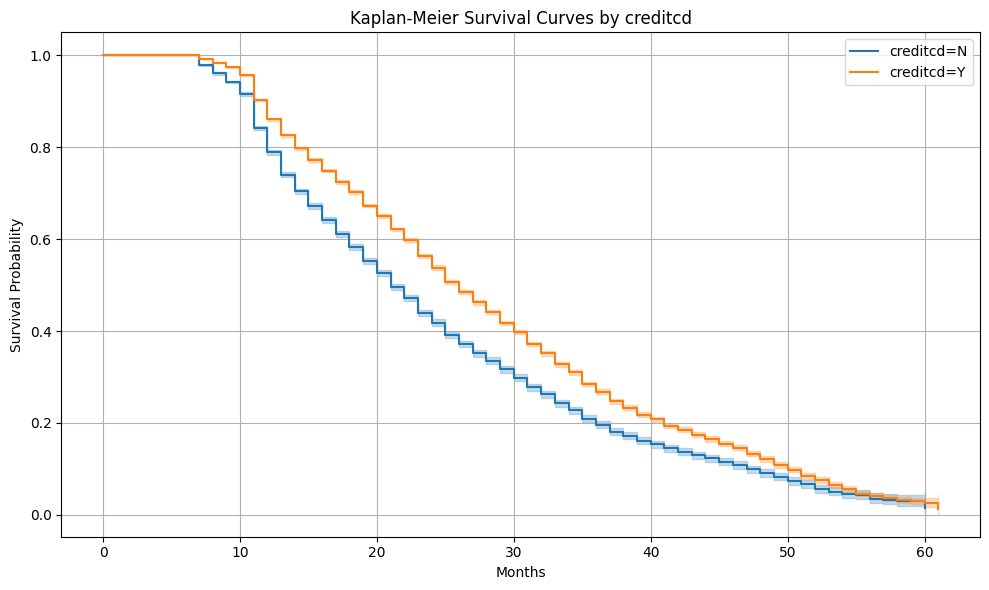

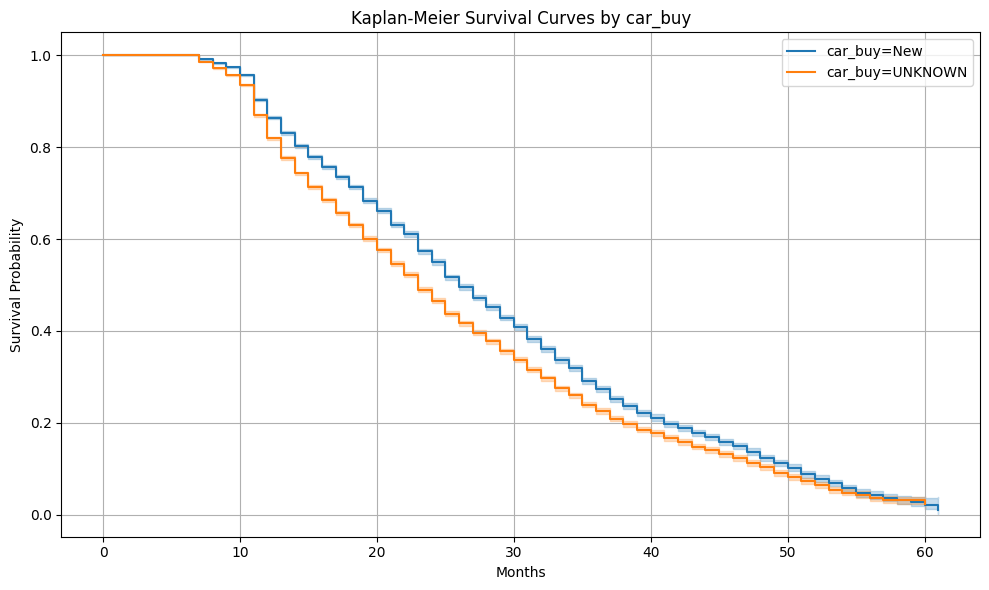

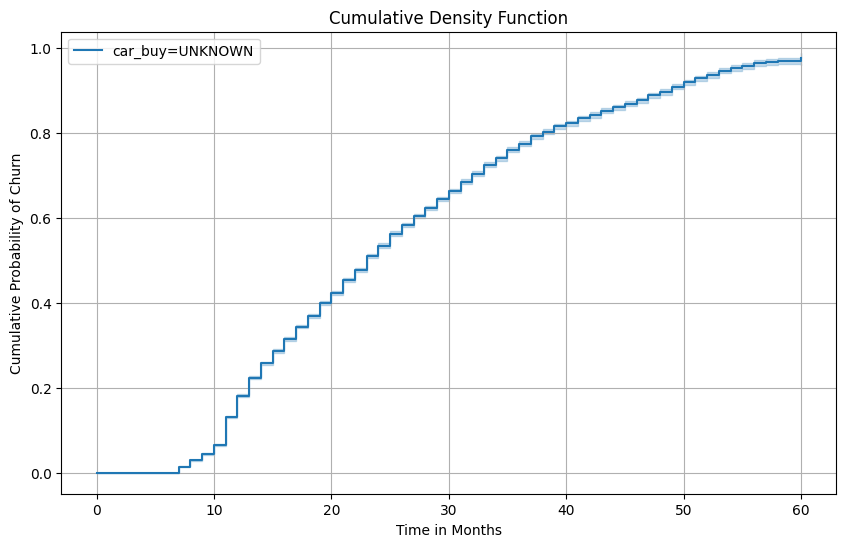

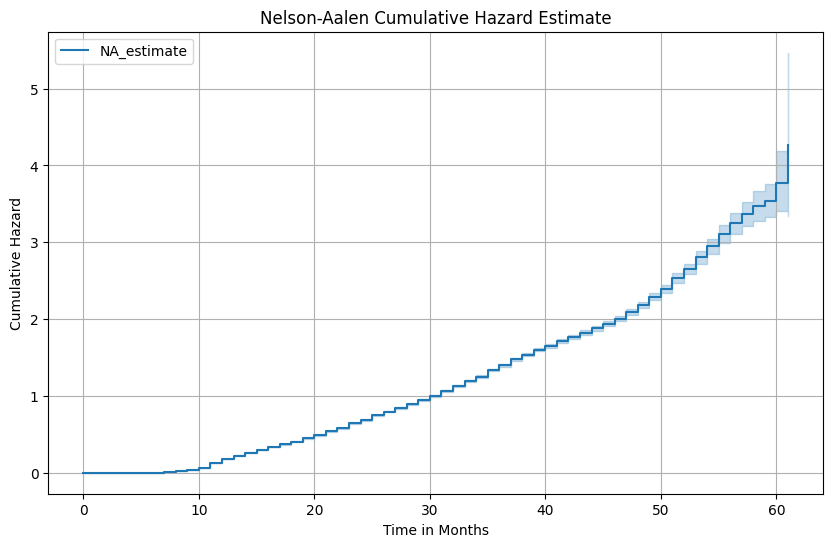

In [19]:
# ## 3. Kaplan-Meier Survival Estimation

from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
kmf.fit(durations=cell1_final['months'], event_observed=cell1_final['churn'])
kmf.plot_survival_function(ci_show=True)
plt.title("Kaplan-Meier Survival Function")
plt.xlabel("Time in Months")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()



# Stratified Kaplan-Meier by all categorical variables with <= 10 unique values
from lifelines import KaplanMeierFitter

categorical_cols = [col for col in cell1.columns if cell1[col].dtype == 'object' and cell1[col].nunique() <= 10]

for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    for level in sorted(cell1[col].dropna().unique()):
        mask = cell1[col] == level
        kmf = KaplanMeierFitter()
        kmf.fit(durations=cell1['months'][mask], event_observed=cell1['churn'][mask], label=f"{col}={level}")
        kmf.plot_survival_function(ci_show=True)
    plt.title(f"Kaplan-Meier Survival Curves by {col}")
    plt.xlabel("Months")
    plt.ylabel("Survival Probability")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Plot Cumulative Density Function (CDF)
plt.figure(figsize=(10, 6))
kmf.plot_cumulative_density()
plt.title("Cumulative Density Function")
plt.xlabel("Time in Months")
plt.ylabel("Cumulative Probability of Churn")
plt.grid(True)
plt.show()

# Nelson-Aalen estimator
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()
naf.fit(durations=cell1_final['months'], event_observed=cell1_final['churn'])

plt.figure(figsize=(10, 6))
naf.plot()
plt.title("Nelson-Aalen Cumulative Hazard Estimate")
plt.xlabel("Time in Months")
plt.ylabel("Cumulative Hazard")
plt.grid(True)
plt.show()



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:23:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


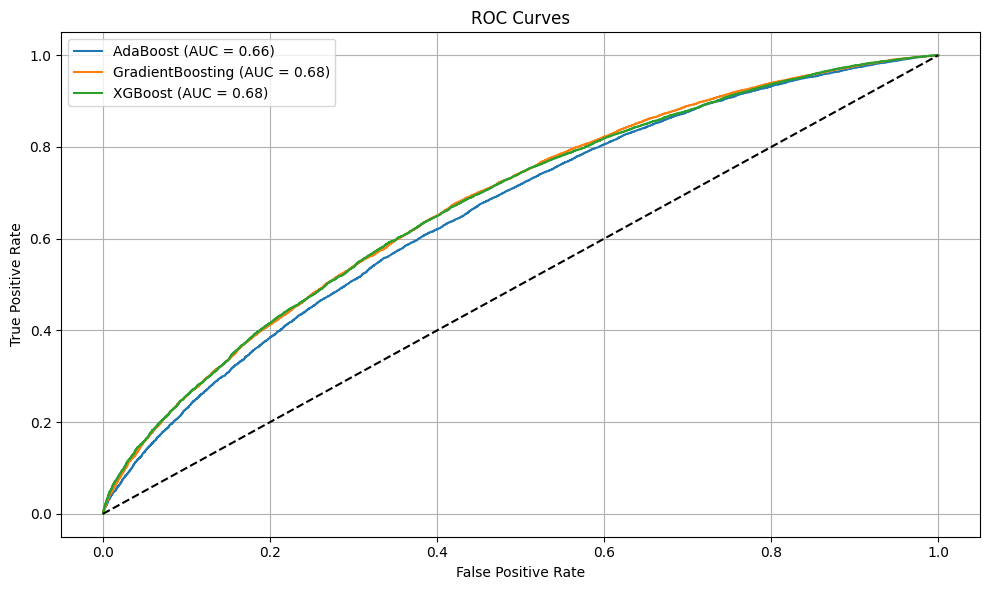

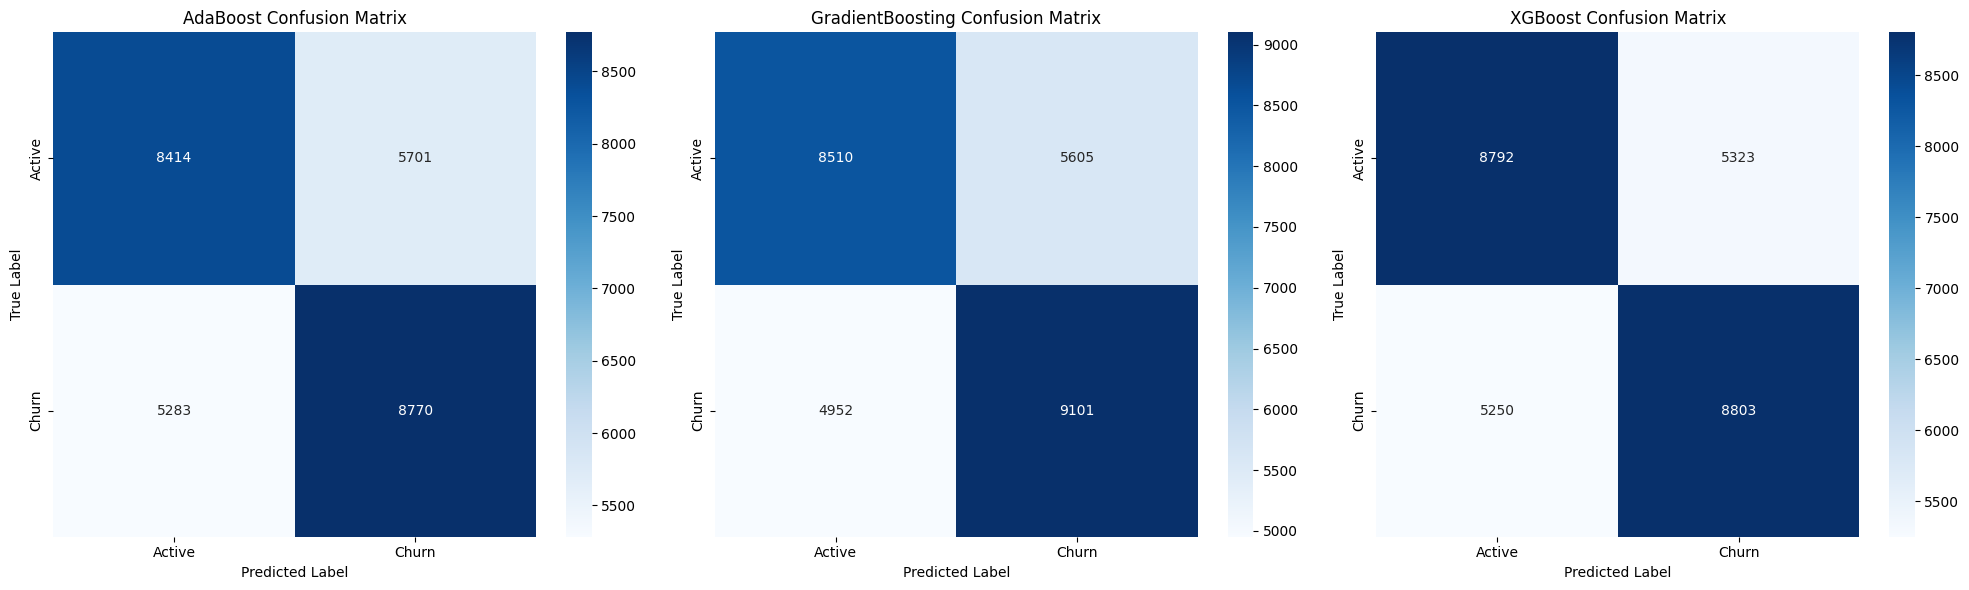


AdaBoost Classification Report:

              precision    recall  f1-score   support

         0.0       0.61      0.60      0.61     14115
         1.0       0.61      0.62      0.61     14053

    accuracy                           0.61     28168
   macro avg       0.61      0.61      0.61     28168
weighted avg       0.61      0.61      0.61     28168


GradientBoosting Classification Report:

              precision    recall  f1-score   support

         0.0       0.63      0.60      0.62     14115
         1.0       0.62      0.65      0.63     14053

    accuracy                           0.63     28168
   macro avg       0.63      0.63      0.63     28168
weighted avg       0.63      0.63      0.63     28168


XGBoost Classification Report:

              precision    recall  f1-score   support

         0.0       0.63      0.62      0.62     14115
         1.0       0.62      0.63      0.62     14053

    accuracy                           0.62     28168
   macro avg       

In [21]:
# ## 5. Classification Models for Churn Prediction

# Split features/target
X = cell1_final.drop(columns=['churn'])
y = cell1_final['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix

models = {
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}
plt.figure(figsize=(10, 6))
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    results[name] = (model, y_pred)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ## 6. Confusion Matrices


import seaborn as sns
from sklearn.metrics import confusion_matrix

# Human-readable labels
labels = ["Active", "Churn"]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for ax, (name, (model, y_pred)) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=labels, yticklabels=labels)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()

# ## 7. Classification Reports

for name, (model, y_pred) in results.items():
    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_test, y_pred))



🔧 Tuning AdaBoost...
✅ Best Parameters for AdaBoost: {'learning_rate': np.float64(0.37997993265440233), 'n_estimators': 124}
              precision    recall  f1-score   support

      Active       0.61      0.51      0.56     14115
       Churn       0.58      0.67      0.62     14053

    accuracy                           0.59     28168
   macro avg       0.59      0.59      0.59     28168
weighted avg       0.59      0.59      0.59     28168


🔧 Tuning GradientBoosting...
✅ Best Parameters for GradientBoosting: {'learning_rate': np.float64(0.05846173685406504), 'max_depth': 4, 'n_estimators': 87}
              precision    recall  f1-score   support

      Active       0.63      0.59      0.61     14115
       Churn       0.62      0.65      0.63     14053

    accuracy                           0.62     28168
   macro avg       0.62      0.62      0.62     28168
weighted avg       0.62      0.62      0.62     28168


🔧 Tuning XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:40:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Best Parameters for XGBoost: {'learning_rate': np.float64(0.05846173685406504), 'max_depth': 4, 'n_estimators': 87}
              precision    recall  f1-score   support

      Active       0.63      0.59      0.61     14115
       Churn       0.62      0.66      0.64     14053

    accuracy                           0.62     28168
   macro avg       0.62      0.62      0.62     28168
weighted avg       0.62      0.62      0.62     28168



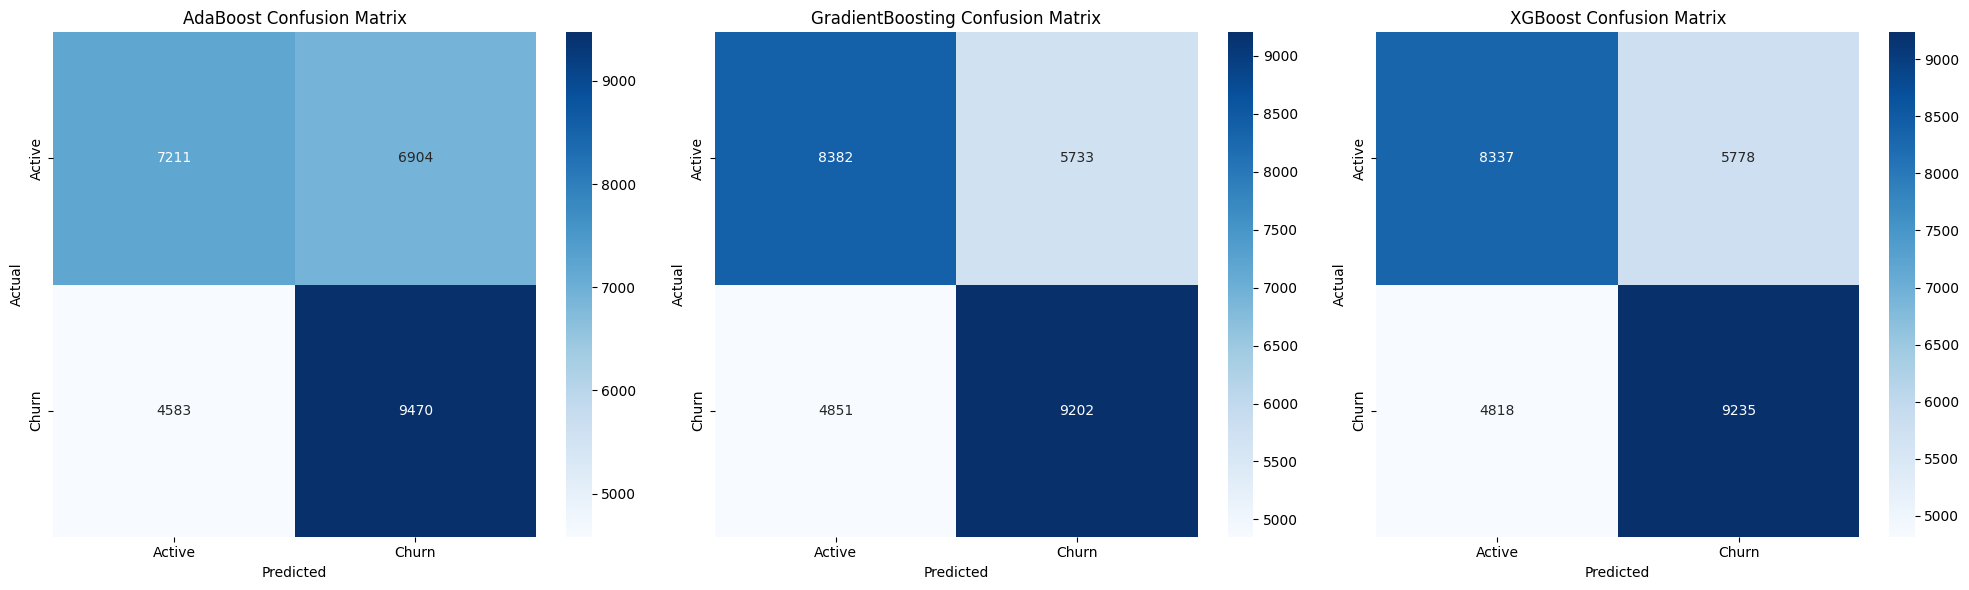

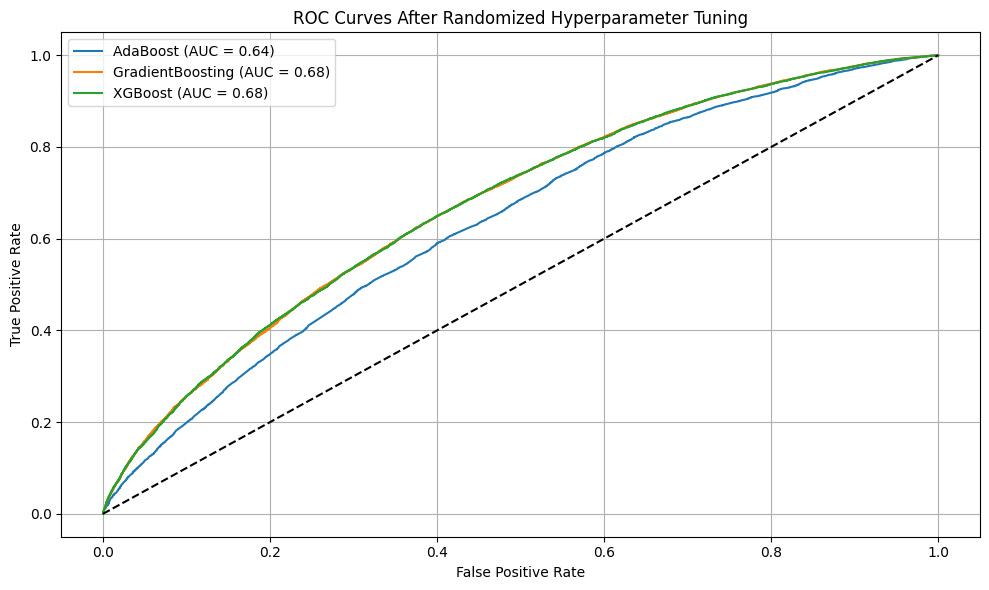

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define smaller, randomized parameter spaces
from scipy.stats import uniform, randint

param_dists = {
    "AdaBoost": {
        "n_estimators": randint(50, 150),
        "learning_rate": uniform(0.3, 0.8)
    },
    "GradientBoosting": {
        "n_estimators": randint(50, 150),
        "learning_rate": uniform(0.05, 0.15),
        "max_depth": randint(3, 6)
    },
    "XGBoost": {
        "n_estimators": randint(50, 150),
        "learning_rate": uniform(0.05, 0.15),
        "max_depth": randint(3, 6)
    }
}

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

models = {
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

tuned_models = {}
classification_results = {}
roc_curves = {}

for name in models:
    print(f"\n🔧 Tuning {name}...")
    rand_search = RandomizedSearchCV(
        models[name],
        param_distributions=param_dists[name],
        n_iter=10,  # only 10 random combinations
        scoring="f1",
        cv=2,
        n_jobs=-1,
        random_state=42
    )
    rand_search.fit(X_train_scaled, y_train)
    best_model = rand_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=["Active", "Churn"])
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    tuned_models[name] = best_model
    classification_results[name] = {"confusion": cm, "report": report, "auc": auc}
    roc_curves[name] = (fpr, tpr)

    print(f"✅ Best Parameters for {name}: {rand_search.best_params_}")
    print(report)

# 🔲 Plot Confusion Matrices
labels = ["Active", "Churn"]
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for ax, (name, result) in zip(axes, classification_results.items()):
    sns.heatmap(result["confusion"], annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=labels, yticklabels=labels)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

# 📈 Plot ROC Curves
plt.figure(figsize=(10, 6))
for name, (fpr, tpr) in roc_curves.items():
    auc = classification_results[name]["auc"]
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves After Randomized Hyperparameter Tuning")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
pip install tensorflow


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.5264 - auc: 0.5356 - loss: 0.8064 - val_accuracy: 0.5758 - val_auc: 0.6066 - val_loss: 0.6777
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5524 - auc: 0.5705 - loss: 0.7038 - val_accuracy: 0.5854 - val_auc: 0.6226 - val_loss: 0.6712
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5739 - auc: 0.6054 - loss: 0.6794 - val_accuracy: 0.5948 - val_auc: 0.6327 - val_loss: 0.6666
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5933 - auc: 0.6274 - loss: 0.6692 - val_accuracy: 0.6006 - val_auc: 0.6372 - val_loss: 0.6642
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6014 - auc: 0.6417 - loss: 0.6620 - val_accuracy: 0.5999 - val_auc: 0.6403 - val_loss: 0.6622
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6047 - auc: 0.6482 - loss: 0.6589 - val_accuracy: 0.6036 - val_auc: 0.6399 - val_loss: 0.6621
Epoch 7/50
206/206 ━━━━━━━━━━━━━━

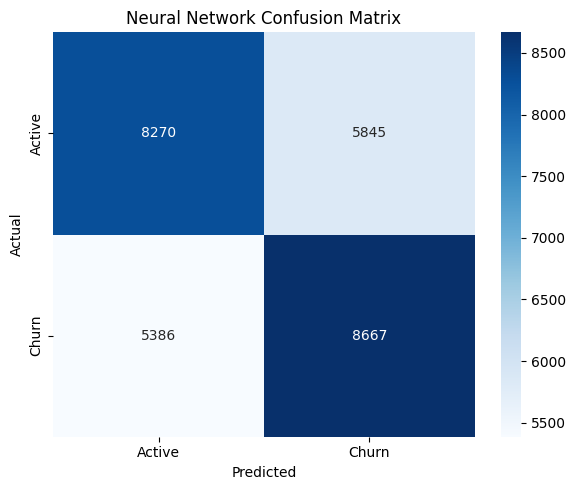

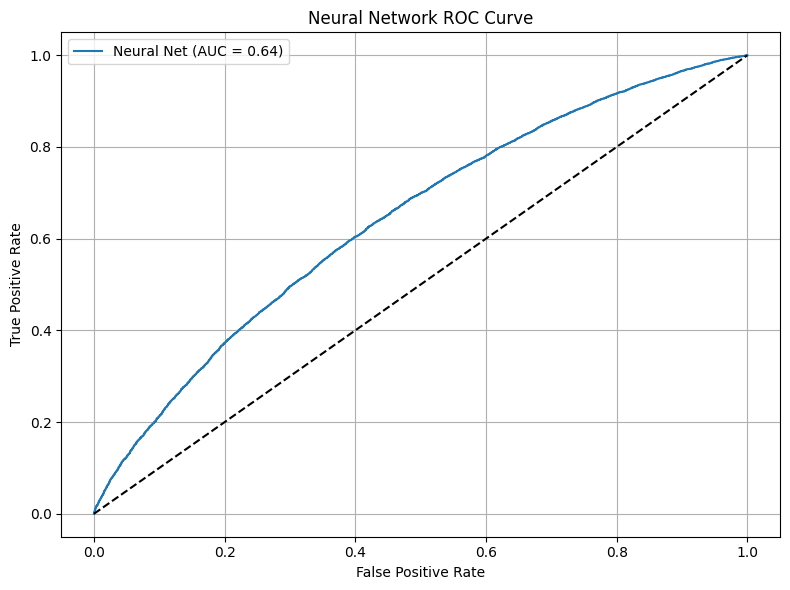

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the neural network architecture
def build_nn(input_dim):
    model = Sequential([
        Dense(256, input_dim=input_dim, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

# Build and train the model
model = build_nn(X_train_scaled.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate the model
y_pred_prob = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

# Metrics
print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Active", "Churn"]))

auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\n✅ ROC AUC: {auc_score:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Active", "Churn"], yticklabels=["Active", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Neural Network Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Neural Net (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Neural Network ROC Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
